In [144]:
import pandas as pd
from api.database import *
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import re
from collections import Counter
import unicodedata
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(1)
#python -m spacy download corpus_name

In [15]:
def test_df_loading():
    d = get_df("SELECT nom, text, x, y from deputes join texts on texts.deputes_id = deputes.id LIMIT 10")
    df = pd.DataFrame(d)
    print(df)

d = get_df("SELECT nom, text, x, y from deputes join texts on texts.deputes_id = deputes.id LIMIT 10")
df = pd.DataFrame(d)
corpus_a = "fr_dep_news_trf"
corpus_e = "fr_core_news_sm"

In [19]:


def separe_to_sentences(text, efficiency = True):
    corpus = corpus_e if efficiency else corpus_a
    nlp = spacy.load(corpus)
    doc = nlp(text)
    assert doc.has_annotation("SENT_START")
    return [unicodedata.normalize("NFKD", sent.text)  for sent in doc.sents]

def process_text(text, efficiency = True):
    text = re.sub(r'\([^)]*\)', '', text)
    corpus = corpus_e if efficiency else corpus_a
    nlp = spacy.load(corpus)
    doc = nlp(text)
    t = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return t

def create_lexic(d2, size = 1000):
    df2 = pd.DataFrame(d2)
    df2["cleaned_text"] = df2["text"].apply(process_text)
    df2["n_words"] = df2["cleaned_text"].apply(len)
    df2 = df2[df2.n_words > 1]
    c = dict(Counter(df2["cleaned_text"].sum()))
    so = sorted(c.items(), key = lambda x:x[1], reverse = True)
    d = dict(so[:size])
    return list(d.keys())


    
def separe_dictionnary_by_sentences(d):
    d2 = {k:[] for k in d.keys()}
    for nom, text, x, y in tqdm(list(zip(d["nom"], d["text"], d["x"], d["y"]))):
        sentences = separe_to_sentences(text, efficiency = True)
        for sentence in sentences:
            if len(sentences) < 15:
                continue
            d2["nom"].append(nom)
            d2["x"].append(x)
            d2["y"].append(y)
            d2["text"].append(sentence)
    return d2

In [ ]:
d = get_df("SELECT nom, text, x, y from deputes join texts on texts.deputes_id = deputes.id LIMIT 10")
df = pd.DataFrame(d)
lexic = create_lexic(d, size = 1000)
df["cleaned_text"] = df["text"].apply(process_text)
df["cleaned_text"] = df["cleaned_text"].apply(lambda x:[i for i in x if i in lexic])
df["text"] = df["cleaned_text"].apply(lambda x:" ".join(x))

## Without embedding

In [109]:
d = get_df("SELECT nom, text, x, y from deputes join texts on texts.deputes_id = deputes.id LIMIT 100")
df = pd.DataFrame(d)
df["cleaned_text"] = df["text"].apply(process_text)
lexic = create_lexic(d, size = 1000)
df["cleaned_text"] = df["cleaned_text"].apply(lambda x:[i for i in x if i in lexic])
df["text"] = df["cleaned_text"].apply(lambda x:" ".join(x))

In [110]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(df["text"]))

In [111]:
vectorizer.transform([df["text"][0]])

<1x4091 sparse matrix of type '<class 'numpy.float64'>'
	with 228 stored elements in Compressed Sparse Row format>

In [112]:
vectorizer.get_feature_names_out().shape

(4091,)

In [113]:
class TFIDF_NN(nn.Module):

    def __init__(self, vect, hidden_size = 100):
        super(TFIDF_NN, self).__init__()
        self.vectorizer = vect
        vocab_size = vect.get_feature_names_out().shape[0]
        self.linear1 = nn.Linear(vocab_size, hidden_size)
        self.output = nn.Linear(hidden_size, 2)


    def forward(self, text):
        inputs = torch.tensor(self.vectorizer.transform(text).toarray()).float()
        h1 = F.relu(self.linear1(inputs))
        output = self.output(h1)
        return output


In [114]:
model = TFIDF_NN(vectorizer)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(10000):
    y_pred = model(df["text"])
    y_true = torch.tensor(np.array(df[["x", "y"]])).float()
    loss = loss_fn(y_pred, y_true)
    if t % 250 == 0:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 25711372.0
250 478220.78125
500 56598.73046875
750 9529.80078125


KeyboardInterrupt: 

## Sans préprocessing
Parce que ça prend putain de trop de temps bordel

In [189]:
d = get_df("SELECT nom, text, x, y from deputes join texts on texts.deputes_id = deputes.id LIMIT 50000")
df = pd.DataFrame(d)
### Je désactive le préprocessing pour povuoir tester plus de députés
#df["cleaned_text"] = df["text"].apply(process_text)
#lexic = create_lexic(d, size = 1000)
#df["cleaned_text"] = df["cleaned_text"].apply(lambda x:[i for i in x if i in lexic])
#df["text"] = df["cleaned_text"].apply(lambda x:" ".join(x))

In [190]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(df["text"]))
X.shape

(50000, 4094)

In [ ]:
model = TFIDF_NN(vectorizer)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in tqdm(range(5000)):
    y_pred = model(df["text"])
    y_true = torch.tensor(np.array(df[["x", "y"]])).float()
    loss = loss_fn(y_pred, y_true)
    if t % 200 == 0:
        print(t)
        print("Training: ", loss.item())
        d2 = df.sample(n=100)
        yt = torch.tensor(np.array(d2[["x", "y"]])).float()
        pt = model(d2["text"])
        loss2 = loss_fn(yt, pt)
        print("Test: ", loss2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

0
Training:  13193162752.0
Test:  22781130.0
200
Training:  520369792.0
Test:  582742.6875
400
Training:  51730544.0
Test:  102707.875
600
Training:  13210376.0
Test:  24837.6484375
800
Training:  2374870.0
Test:  132.81752014160156
1000
Training:  334279.8125
Test:  1250.026123046875
1200
Training:  47045.58984375
Test:  2.1281895637512207
1400
Training:  6427.9658203125
Test:  0.5159042477607727
1600
Training:  720.2836303710938
Test:  1.3688184022903442
1800
Training:  60.25787353515625
Test:  0.005270300433039665


In [183]:
ex = """
La crise aurait pu être l’occasion de remettre en question le bien-fondé de la croissance du trafic aérien. Après tout, un trajet en avion – vous le savez, monsieur le ministre délégué – est en moyenne quatorze à quarante fois plus polluant qu’en train. Le trafic aérien double tous les quinze ans et la filière est responsable de plus de 7 % de l’empreinte carbone de la France. Peut-être serait-il alors plus sage d’amorcer la bifurcation écologique ? Mais non ! Saupoudrez comme il vous plaira, et sans garanties écologiques."""

In [184]:
depute_df = get_df("SELECT nom, x, y from deputes")
depute_df = pd.DataFrame(depute_df)


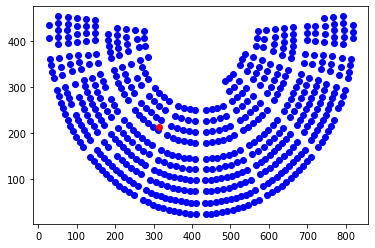

In [185]:
plt.scatter(depute_df["x"], depute_df["y"], c = "blue")
o = model([ex]).detach().numpy()[0]
x,y = o[0], o[1]
plt.scatter([x],[y], c = "red")

In [154]:
o

tensor([[358.2219, 176.0823]], grad_fn=<AddmmBackward0>)